In [6]:
from plotnine import *
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # simple TT split cv
import numpy as np
import seaborn as sb

from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Review

Principal component analysis (PCA) is a method of *dimensionality reduction* that takes the information in multiple variables/predictors, and presents that information (or at least MOST of it) in a smaller number of features. This smaller number of features--called components--are all linear combinations of the original variables, and the features are created in a way (eigendecomposition, if you're interested!) that makes the 1st component contain the MOST variability in the data, the 2nd component contain the second most variability...and so on.

This allows us to choose only a handful of features (usually the first N features) that contain *most* of the information from the original data. This is helpful becuase few features often means faster models.

We discussed 2 ways to choose the number of components that you retain:


* a) **The Elbow Method**: create a scree plot, and find the "elbow" of the graph. Retain all the components at and before the elbow.
* b) **The Percentage Method**: specify a specific % of variance that's acceptable to retain (e.g. 95%), and retain enough components to achieve that %.
    
    
    
<img src="https://drive.google.com/uc?export=view&id=1crCW8BAFVEu50th9VhdJMYakZho03kp0" width = 500px />

# PCA Visually
<img src="https://drive.google.com/uc?export=view&id=1wBXkUp2MNZSSrnXhHsqNYmdYhC9Bs6x1" height = 200px />
<img src="https://drive.google.com/uc?export=view&id=1ZHMOB5oDdogQgBBqTTrKfEnexXjPwEWS" height = 200px />


## `sklearn`: A Simple PCA for Compression
Let's use [this data](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/penguins.csv) to perform PCA on penguin body features.

In [7]:
# load in data
penguin = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/penguins.csv")
penguin.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


C:\Users\ryanj\AppData\Local\Temp\ipykernel_30416\4198342873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


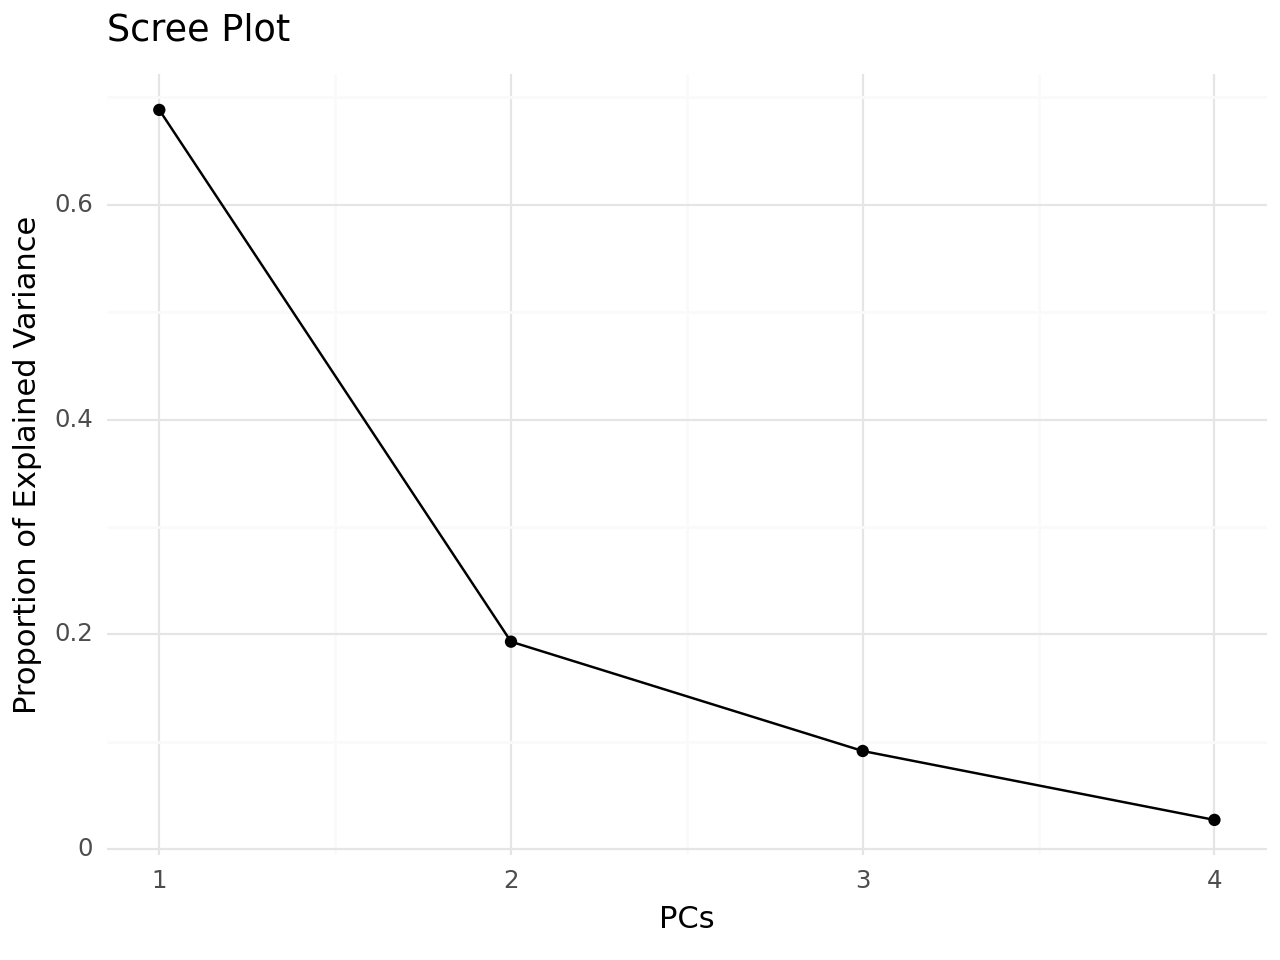

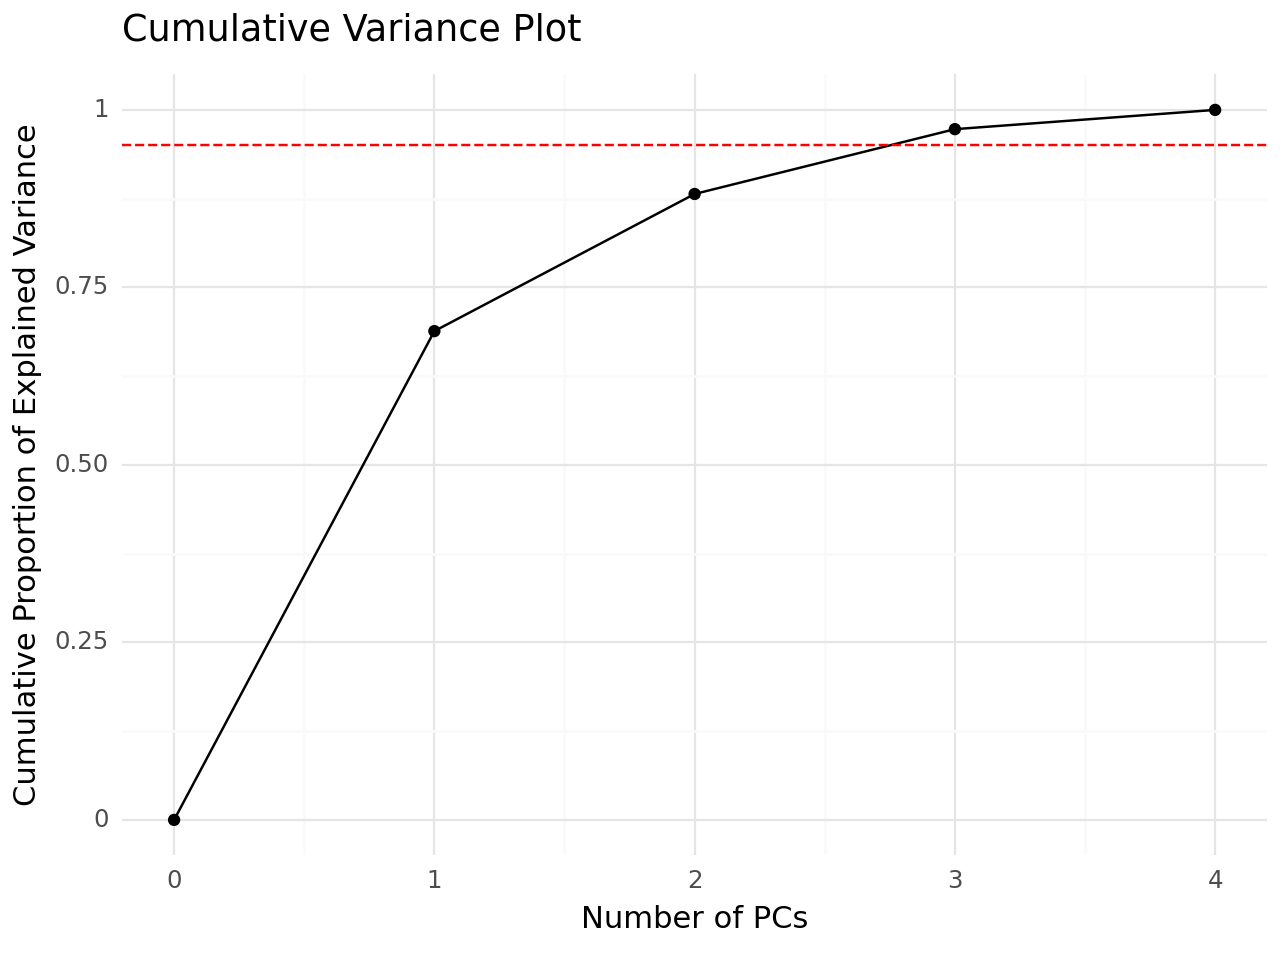

In [8]:
# create X
feats = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
penguin_sub = penguin[feats]

penguin_sub.dropna(inplace = True)
penguin_sub.reset_index(inplace = True, drop = True)


# empty pipeline
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

pca = PCA()

pipe_penguin = Pipeline([
    ("z", z),
    ("pca", pca)
])

# fit
pipe_penguin.fit(penguin_sub)

# scree/cumvar plot
pcaDF = pd.DataFrame({"expl_var" :
                      pipe_penguin.named_steps["pca"].explained_variance_ratio_,
                      "pc": range(1,5),
                      "cum_var":
                      pipe_penguin.named_steps["pca"].explained_variance_ratio_.cumsum()})

# scree
print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

# cumulative variance
pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})]) # add 0,0 for reference

print(ggplot(pcaDF0, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.95, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance", title = "Cumulative Variance Plot"))

In [9]:
penguin_PCs = pd.DataFrame(pipe_penguin.transform(penguin_sub))

penguin_PCs.columns = ["PC" + str(i+1) for i in range(len(feats))]
penguin_PCs
#penguin_PCs.head()


,PC1,PC2,PC3,PC4
0,-1.843445,0.047702,-0.232794,0.523903
1,-1.306762,-0.428348,-0.029562,0.402426
2,-1.369181,-0.154476,0.198672,-0.528007
3,-1.878827,-0.002048,-0.618596,-0.478378
4,-1.911748,0.829210,-0.686584,-0.207428
...,...,...,...,...
337,0.565610,2.352188,0.891489,-0.394346
338,-0.732380,0.253368,0.328192,-0.733235
339,-0.355706,0.999910,0.897282,0.195026
340,0.502033,1.491983,0.346226,-0.554713


## `sklearn`: Using PCs as Predictors in a Supervised Model

Using `data`, run PCA on the predictors (V1-V11), then build a model that uses the first 1,3,5,10, and 11 components.

* How much variance do the 1,3,5,10, and 11 components cover?
* How does each model do on train/test accuracy? How do they do compared to the full model?
* What patterns do you observe, and why do you think those patterns exist?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

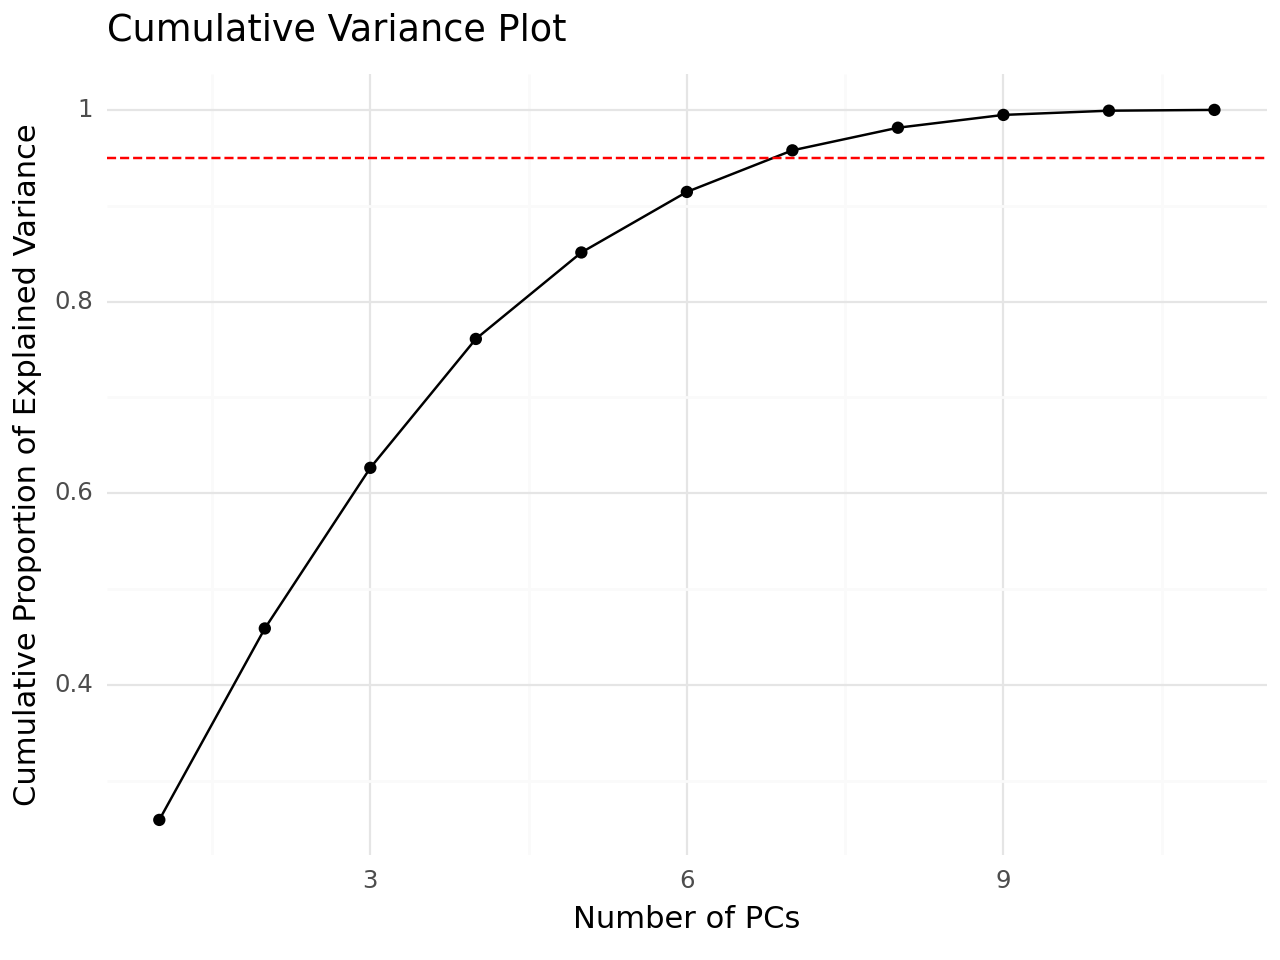

In [5]:
# load in data
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pcaLogit.csv")
data.head()

# set up X 
feats = ["V" + str(i) for i in range(1,12)]
X = data[feats]
y = data["Outcome"]

# tts
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2)

# empty pipeline
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

pca = PCA()

pipe_pca = Pipeline([
    ("z", z),
    ("pca", pca)
])

# fit
pipe_pca.fit(X_train)

# scree/cumvar plot
pcaDF = pd.DataFrame({"expl_var" :
                      pipe_pca.named_steps["pca"].explained_variance_ratio_,
                      "pc": range(1,12),
                      "cum_var":
                      pipe_pca.named_steps["pca"].explained_variance_ratio_.cumsum()})

# print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
#  theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

print(ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.95, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance", title = "Cumulative Variance Plot"))

In [6]:
# empty pipeline
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

pca = PCA(n_components = 11)

pipe_lr = Pipeline([
    ("z", z),
    ("pca", pca),
    ("model", LogisticRegression())
])

# fit
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('z',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11'])])),
                ('pca', PCA(n_components=11)),
                ('model', LogisticRegression())])

In [7]:
y_pred_train = pipe_lr.predict(X_train)
y_pred_test  = pipe_lr.predict(X_test)

y_pred_train_prob = pipe_lr.predict_proba(X_train)[:,1]
y_pred_test_prob  = pipe_lr.predict_proba(X_test)[:,1]

# assess
print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train Prescision: ", precision_score(y_train, y_pred_train))
print("Train Recall    : ", recall_score(y_train, y_pred_train))
print("Train F1        : ", f1_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))


print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test Prescision : ", precision_score(y_test, y_pred_test))
print("Test Recall     : ", recall_score(y_test, y_pred_test))
print("Test F1         : ", f1_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.9875
Train Prescision:  0.9722222222222222
Train Recall    :  1.0
Train F1        :  0.9859154929577464
Train ROC AUC   :  0.9993650793650793
Test Acc        :  0.85
Test Prescision :  0.9090909090909091
Test Recall     :  0.8333333333333334
Test F1         :  0.8695652173913043
Test ROC AUC    :  0.9166666666666667


# Classwork

## PCA with different variable correlations

You can grab all pairwise correlations between variables/features in your model by using the command [`df.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) where `df` is your dataframe, and `sb.heatmap(df.corr(), cmap="Blues", annot=True)`.

For the following datasets:

1. Look at the correlations between all the variables in the dataframe. Are they high? low?
2. Build an Empty Pipeline with Z scoring and PCA
3. Fit the Model
4. Make a Cumulative Variance plot (be sure to add `+ ylim(0,1)`. What do you notice about the patterns in the screeplot? How do those relate to the correlations you saw?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />


TIP: to make the scree plot more clear, it can help to add the row [0,0,0] to your dataframe of the explained/cumulative variance. You can do this with:

In [ ]:
# THIS CODE WON'T RUN, it's just an example of how to do this
pcaDF = pd.DataFrame({"expl_var" : pipe.named_steps["pca"].explained_variance_ratio_, "pc": range(1,12),
                      "cum_var": pipe.named_steps["pca"].explained_variance_ratio_.cumsum()})

# add zeros
pcaDF = pcaDF.append(pd.DataFrame({"expl_var" : [0], "pc": [0], "cum_var": [0]}))

In [ ]:
d1 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca0.csv")
d1.head()


In [ ]:
d2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca5.csv")
d2.head()


In [ ]:
d3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca9.csv")
d3.head()

In [ ]:
d4 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca10.csv")
d4.head()


In [ ]:
d5 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca11.csv")
d5.head()


In [ ]:
# NOTE: this has different variable names and a different # of columns
d6 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/pca12.csv")
d6.head()


## PCA and clustering

Using the McDonald's Nutritional Data found here: https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Data/McMenu.csv (see [Kaggle](https://www.kaggle.com/mcdonalds/nutrition-facts/version/1) for more info), use k-means with k = 4 to cluster the foods using all the variables except category, item, and serving size (make sure to z score variables first!).

Next, perform PCA on all the variables except category, item, and serving size. Calculate and grab the first 2 PCs, and add them to your dataframe.

Normally (like in your project) when we have more than 2 variables, we have to make MULTIPLE plots. But, one other option is to plot the first 2 PCs, and then color by cluster. Even though we are losing *some* information, we're still roughly able to see how cohesive/dense/separate our clusters are! Try making a scatterplot using the first 2 PCs, then coloring by cluster. What can you tell about your clusters?

In [ ]:
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
d = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/McMenu.csv")
d.head()

In [ ]:
### YOUR CODE HERE ####

# grab columns we want to use
names = [n for n in d.columns if n not in ["Category", "Item", "Serving Size"]]

# X
X = d[names]

# create empty pipeline
pipe_pca = ???

# fit pipeline and grab cluster assignments
labels = ???





In [ ]:
# create empty pipeline


# fit pipeline


# grab 2 components and add them to d
d["clusters"] = labels
d[["pc1", "pc2"]] = pd.DataFrame(pipe_pca.transform(d[names]))

In [ ]:
# plot
### /YOUR CODE HERE ####